In [0]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import torch.nn.functional as F
from torch import nn

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
transform_trf = transforms.Compose([
#                                     transforms.ToPILImage(),
                                    transforms.Resize((28, 28)),
                                    transforms.ToTensor(),
#                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                    transforms.Normalize([0.5], [0.5]),
#                                     transforms.ToTensor(),
                                    ])
transform_temp = transforms.Compose([transforms.Resize((28,28)),
#                                     transforms.ToTensor(),
#                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                                     transforms.Normalize([0.5], [0.5]),
                                    ])
# it converts the image from range of 0 -> 255 => float tensor in range from 0 -> 1
# we normalize the values for each tensor of image size & height & width
# we specify the standard deviation -> it changes the range to => -1 -> 1
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_trf)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_trf)


training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True) # shuffle the data helps to scape from local mimima and local maximas
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)


0it [00:00, ?it/s]

9920512it [00:07, 1389968.43it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 67816.94it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1154885.77it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 24866.25it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def img_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0) # we reverse the pixels
#   print(image.shape)
  image = image * np.array((0.5, ) + np.array(0.5, )) # denormalization
  image = image.clip(0, 1)
  return image

def img_convert2(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0) # we reverse the pixels
#   print(image.shape)
  image = image * np.array((0.5, 0.5, 0.5) + np.array(0.5, 0.5, 0.5)) # denormalization
  image = image.clip(0, 1)
  return image

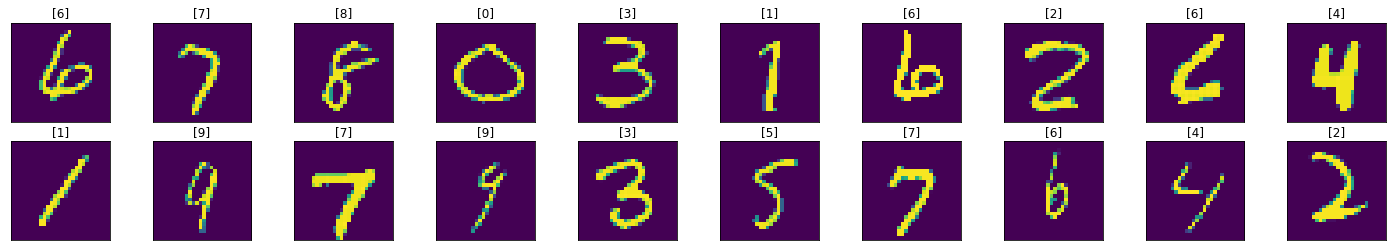

In [0]:
data_iter = iter(training_loader) # it creates an object that allows us to throw the ittrable training loader one element at a time
images, labels = data_iter.next() # it will grab the first batch of out training data
fig = plt.figure(figsize=(25, 4)) # width & height of the figure ...

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[]) # 2 rows & 10 columns!
  plt.imshow(img_convert(images[idx]).squeeze())
  ax.set_title([labels[idx].item()])

In [0]:
class LeNet(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1) # 1: Stride
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1) # 1: Stride
        self.fc1 = nn.Linear(4 * 4 * 50, 500) # 1: Stride
        self.dropout1 = nn.Dropout(0.5) # the probability that a cell being drop out
        self.fc2 = nn.Linear(500, 10) # 1: Stride

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50) # Number of rows in the DS : 4 * 4 * 50 | Number of Columns : -1
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [0]:
model = LeNet().to(device)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# the steps that it takes to arrive to the optimal parameters id dictated by the learning rate
# if the learning rate is too high => the steps it takes will be too large such that the parameters will in a way flip flop back and forth between points. overshooting the minima => leading to the diavegent losses
# generally => decreasing the learning rate allows the model to betterly zero in on the solution for the parameters

In [0]:
epochs = 15
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)


#     print(inputs)
    outputs = model(inputs)
#     print(outputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) # it will give us the number of correct prediction for a single batch of images...

  else:
    with torch.no_grad(): # it will temprerorerly set all the required grad flags to be false
      for val_inputs, val_labels in validation_loader:
#         val_inputs = val_inputs.view(val_inputs.shape[0], -1) # 1, 748 : 
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
    
        
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss / len(training_loader.dataset)
    epoch_acc = running_corrects.float() / len(training_dataset)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss / len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float() / len(validation_dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    
    print("Epoch : ", (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('Validation loss: {:.4f},  validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

    

Epoch :  1
training loss: 0.0057, acc 0.8436 
Validation loss: 0.0018,  validation acc 0.9500 
Epoch :  2
training loss: 0.0015, acc 0.9572 
Validation loss: 0.0011,  validation acc 0.9676 
Epoch :  3
training loss: 0.0010, acc 0.9704 
Validation loss: 0.0007,  validation acc 0.9769 
Epoch :  4
training loss: 0.0008, acc 0.9776 
Validation loss: 0.0006,  validation acc 0.9820 
Epoch :  5
training loss: 0.0006, acc 0.9811 
Validation loss: 0.0005,  validation acc 0.9830 
Epoch :  6
training loss: 0.0006, acc 0.9833 
Validation loss: 0.0005,  validation acc 0.9861 
Epoch :  7
training loss: 0.0005, acc 0.9851 
Validation loss: 0.0004,  validation acc 0.9869 
Epoch :  8
training loss: 0.0004, acc 0.9869 
Validation loss: 0.0004,  validation acc 0.9865 
Epoch :  9
training loss: 0.0004, acc 0.9879 
Validation loss: 0.0004,  validation acc 0.9880 
Epoch :  10
training loss: 0.0004, acc 0.9888 
Validation loss: 0.0004,  validation acc 0.9881 
Epoch :  11
training loss: 0.0003, acc 0.9902 
Va

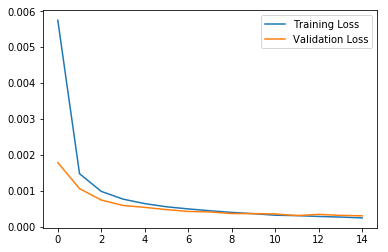

In [0]:
plt.plot(running_loss_history, label='Training Loss')
plt.plot(val_running_loss_history, label='Validation Loss')
plt.legend()

# OverFitting

The more epochs we run -> the training & Validation loss they start to approch one another till at one point the training loss becomes less than the validation loss => there is where you began to overfit the model since what that emplies it is that our model is memorising the training set but then it starts to fail to generalize it's self to the new data on the validation => so realy the number of epochs you train your model on => you have to be careful to not overfit or underfit

overfit => where validation error becomes higher than the training error!
it means it isstarting to memorise it's self!

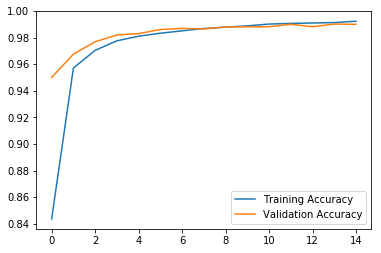

In [0]:
plt.plot(running_correct_history, label="Training Accuracy")
plt.plot(val_running_corrects_history, label='Validation Accuracy')
plt.legend()

In [0]:
!pip3 install pillow

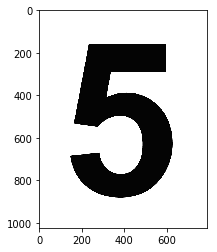

In [0]:
import requests
import PIL
from PIL import Image
url = 'https://martialartsworldnews.com/wp-content/uploads/2015/11/5.jpg'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)
# print(response)

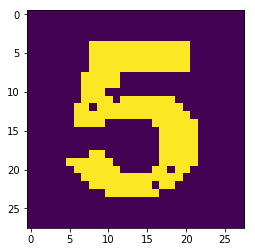

In [0]:
img = PIL.ImageOps.invert(img) # it will invert the colors of the image!
img = img.convert('1') # convert the image to the bionimial (balck - white)
img = transform_temp(img)
# a = np.expand_dims(img, axis=1)
plt.imshow(img)
img = transform_trf(img)

In [0]:
# img = img.view(img.shape[0], -1) # 1, 748 : 
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0) # unsqueeze(0) => a new Tensor with a dimention size of 1
output = model(image)

_, pred = torch.max(output, 1)
print(pred.item())

5


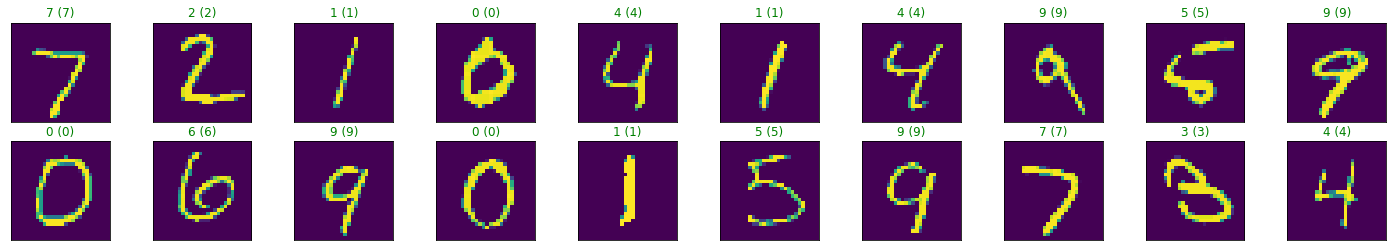

In [0]:
data_iter = iter(validation_loader) # it creates an object that allows us to throw the ittrable training loader one element at a time
images, labels = data_iter.next() # it will grab the first batch of out training data
images = images.to(device)
labels = labels.to(device)
# images_ = images.view(images.shape[0], -1) # 1, 748 :
output = model(images)
_, preds = torch.max(output, 1)
fig = plt.figure(figsize=(25, 4)) # width & height of the figure ...

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[]) # 2 rows & 10 columns!
  plt.imshow(img_convert(images[idx]).squeeze())
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color = ("green" if preds[idx]==labels[idx] else "red"))